In [1]:
import numpy as np
import pandas as pd
import math
import itertools

from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Flatten
from keras.layers import TimeDistributed
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D

import statsmodels.api as sm
from statsmodels.tsa.seasonal import STL

from sklearn.metrics import mean_squared_error

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from pylab import rcParams

Using TensorFlow backend.


In [2]:
import warnings
warnings.filterwarnings("ignore")

# Load and process the data

In [3]:
df = pd.read_csv('AirPassengers.csv')
df['Month'] = pd.to_datetime(df['Month'])
df.head()

,Month,Passengers
0,1949-01-01,112
1,1949-02-01,118
2,1949-03-01,132
3,1949-04-01,129
4,1949-05-01,121


In [4]:
y = pd.Series(data=df['Passengers'].values, index=df['Month'])
y.head()

Month
1949-01-01    112
1949-02-01    118
1949-03-01    132
1949-04-01    129
1949-05-01    121
dtype: int64

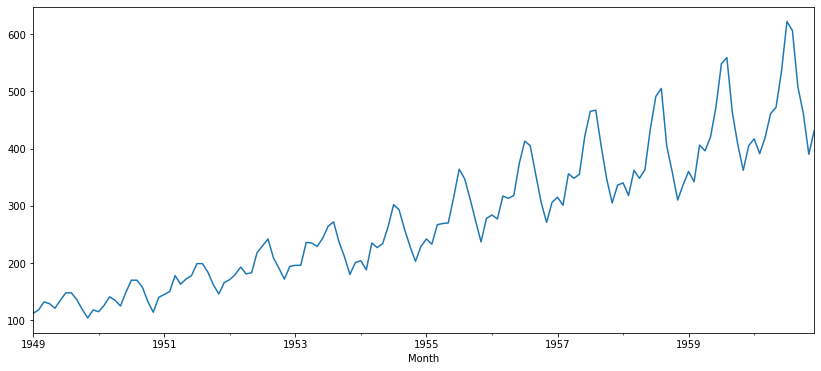

In [5]:
y.plot(figsize=(14, 6))
plt.show()

In [6]:
data = y.values.reshape(y.size,1)

# LSTM Forecast Model

### LSTM Data Preparation

In [7]:
'MixMaxScaler'
scaler = MinMaxScaler(feature_range=(0, 1))
data   = scaler.fit_transform(data)

In [8]:
train_size  = int(len(data) * 0.8)
test_size   = len(data) - train_size
train, test = data[0:train_size,:], data[train_size:len(data),:]
print('data train size :',train.shape[0])
print('data test size  :',test.shape[0])

data train size : 115
data test size  : 29


In [9]:
'function to reshape data according to the number of lags'

def reshape_data (data, look_back,time_steps):
    
    sub_seqs = int(look_back/time_steps)
    dataX, dataY = [], []
    for i in range(len(data)-look_back-1):
        a = data[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(data[i + look_back, 0])
    
    dataX = np.array(dataX)
    dataY = np.array(dataY)
    
    dataX = np.reshape(dataX,(dataX.shape[0],sub_seqs,time_steps,np.size(data,1)))
    return dataX, dataY

In [10]:
look_back = 2
time_steps = 1

trainX, trainY = reshape_data(train, look_back,time_steps)
testX, testY = reshape_data(test, look_back,time_steps)
print('train shape :',trainX.shape)
print('test shape  :',testX.shape)

train shape : (112, 2, 1, 1)
test shape  : (26, 2, 1, 1)


## Define and Fit  the Model

In [11]:
model = Sequential()
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu'), input_shape=(None, time_steps, 1)))

model.add(TimeDistributed(MaxPooling1D(pool_size=1)))
model.add(TimeDistributed(Flatten()))
model.add(LSTM(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

history = model.fit(trainX, trainY, epochs=100, validation_data=(testX, testY), verbose=0)

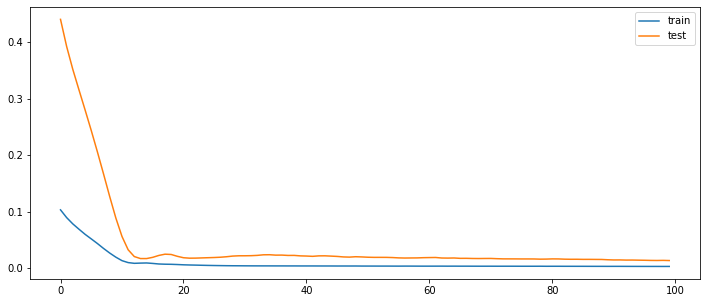

In [12]:
'plot history'
plt.figure(figsize=(12,5))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

## Test the performances

In [13]:
'make predictions'
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

In [14]:
'invert predictions'
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

In [15]:
'calculate root mean squared error' 
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 28.82 RMSE
Test Score: 60.39 RMSE


In [16]:
'shift train predictions for plotting'
trainPredictPlot = np.empty_like(data)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

'shift test predictions for plotting'
testPredictPlot = np.empty_like(data)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(data)-1, :] = testPredict

In [17]:
'Make as pandas series to plot'
data_series = pd.Series(scaler.inverse_transform(data).ravel(), index=df['Month'])
trainPredict_series = pd.Series(trainPredictPlot.ravel(), index=df['Month'])
testPredict_series  = pd.Series(testPredictPlot.ravel(), index=df['Month'])

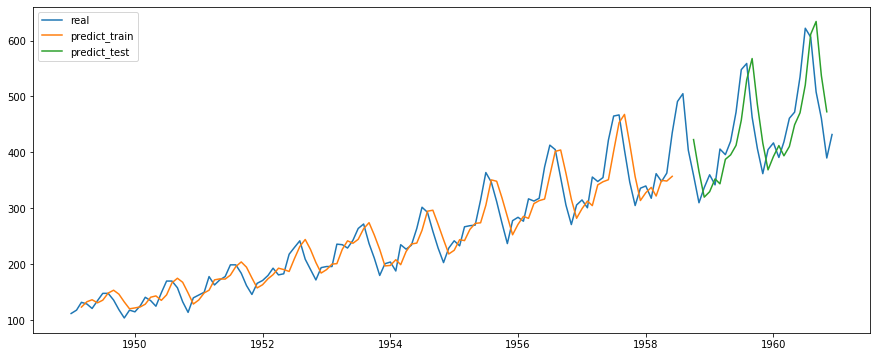

In [18]:
'plot baseline and predictions'
plt.figure(figsize=(15,6))
plt.plot(data_series,label = 'real')
plt.plot(trainPredict_series,label = 'predict_train')
plt.plot(testPredict_series,label = 'predict_test')
plt.legend()
plt.show()

In [19]:
'Predict all the data'
dataX, dataY = reshape_data(data, look_back,time_steps)
dataPredict = model.predict(dataX)

dataPredict = scaler.inverse_transform(dataPredict)
dataY = scaler.inverse_transform([dataY])

dataPredictPlot = np.empty_like(data)
dataPredictPlot[:, :] = np.nan
dataPredictPlot[look_back:len(dataPredict)+look_back, :] = dataPredict

dataPredict_series = pd.Series(dataPredictPlot.ravel(), index=df['Month'])

## STL Decomposing 

In [20]:
predicted = dataPredict_series.dropna()

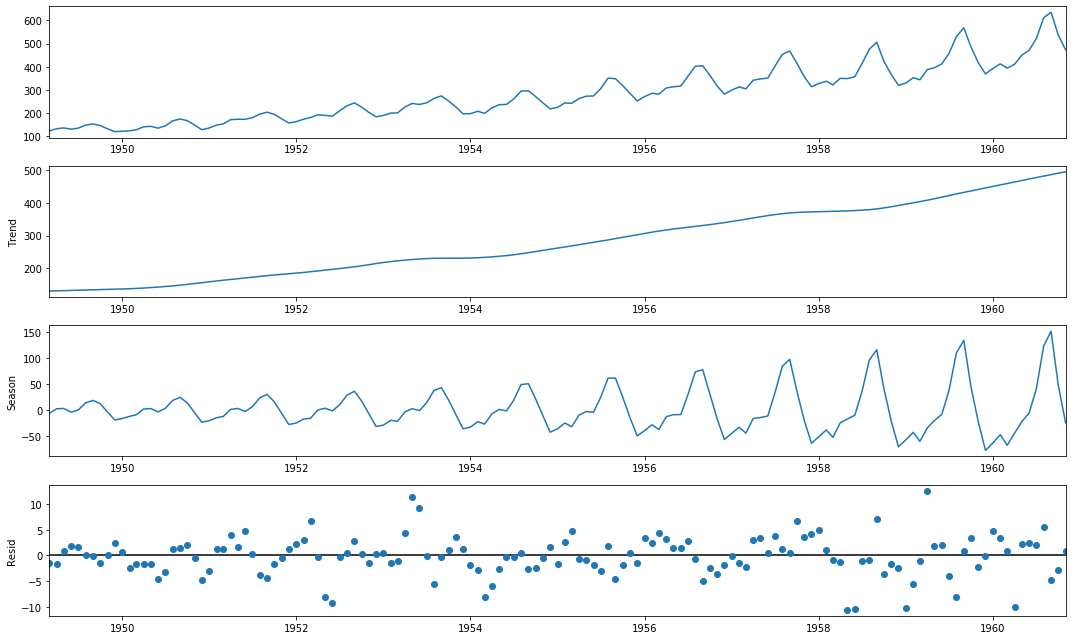

In [21]:
rcParams['figure.figsize'] = 15, 9
stl = STL(predicted).fit()
fig = stl.plot()
plt.show()

## Seasonal plot 

In [22]:
df = predicted.to_frame().reset_index()
df = df.rename(columns= {0: 'Passengers'})
df.head()

,Month,Passengers
0,1949-03-01,123.501839
1,1949-04-01,132.992966
2,1949-05-01,136.558380
3,1949-06-01,131.072784
4,1949-07-01,135.803802


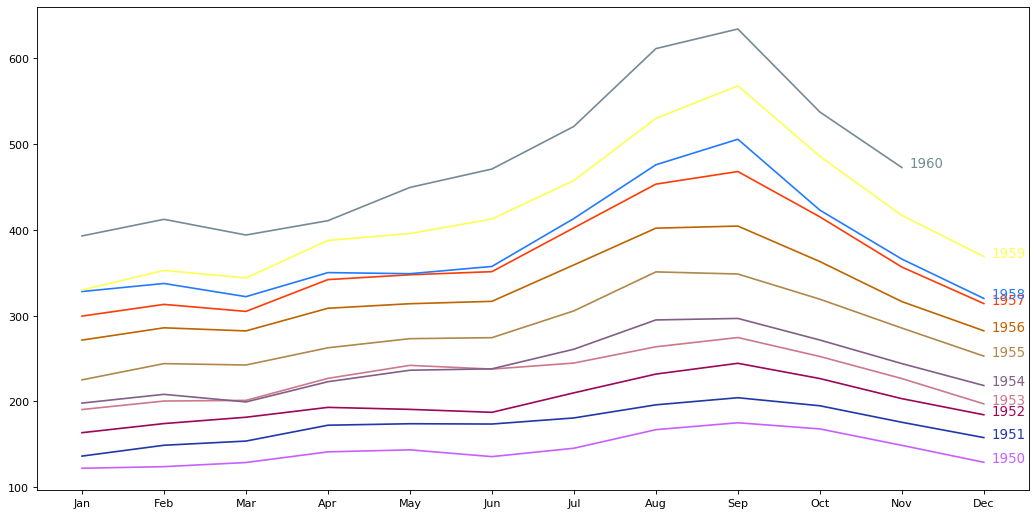

In [23]:
# Prepare data

df['year'] = [d.year for d in df.Month]
df['month'] = [d.strftime('%b') for d in df.Month]
years = df['year'].unique()

# Prep Colors
np.random.seed(100)
mycolors = np.random.choice(list(mpl.colors.XKCD_COLORS.keys()), len(years), replace=False)

# Draw Plot
plt.figure(figsize=(16,8), dpi= 80)
for i, y in enumerate(years):
    if i > 0:        
        plt.plot('month', 'Passengers', data=df.loc[df.year==y, :], color=mycolors[i], label=y)
        plt.text(df.loc[df.year==y, :].shape[0]-.9, df.loc[df.year==y, 'Passengers'][-1:].values[0], y, 
                 fontsize=12, color=mycolors[i])

## Boxplot of Month-wise (Seasonal) and Year-wise (trend) Distribution

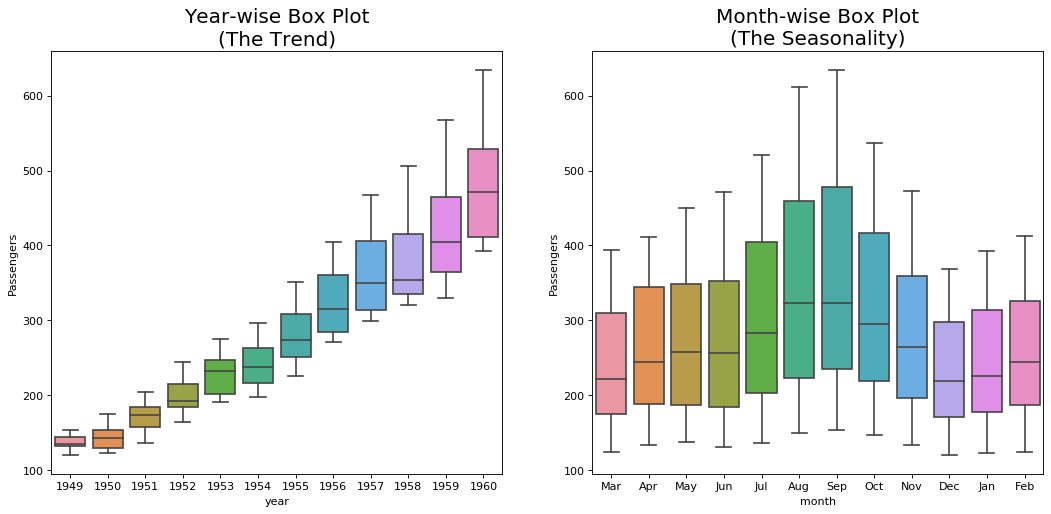

In [24]:
# Draw Plot
fig, axes = plt.subplots(1, 2, figsize=(16,7), dpi= 80)
sns.boxplot(x='year', y='Passengers', data=df, ax=axes[0])
sns.boxplot(x='month', y='Passengers', data=df.loc[~df.year.isin([1991, 2008]), :])

# Set Title
axes[0].set_title('Year-wise Box Plot\n(The Trend)', fontsize=18); 
axes[1].set_title('Month-wise Box Plot\n(The Seasonality)', fontsize=18)
plt.show()

# SARIMA Model

## Grid search the p, d, q parameters

In [25]:
'Define the p, d and q parameters to take any value between 0 and 3'
p = d = q = range(0, 3)

'Generate all different combinations of p, q and q triplets'
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [26]:
warnings.filterwarnings("ignore") # specify to ignore warning messages
best_result = [0, 0, 10000000]
for param in pdq:
    for param_seasonal in seasonal_pdq:
        
        mod = sm.tsa.statespace.SARIMAX(predicted,
                                        order=param,
                                        seasonal_order=param_seasonal,
                                        enforce_stationarity=False,
                                        enforce_invertibility=False)

        results = mod.fit()
            
        print('ARIMA{} x {} - AIC: {}'.format(param, param_seasonal, results.aic))

        if results.aic < best_result[2]:
            best_result = [param, param_seasonal, results.aic]
print('\nBest Result:', best_result)

ARIMA(0, 0, 0) x (0, 0, 0, 12) - AIC: 2001.6993044567193
ARIMA(0, 0, 0) x (0, 0, 1, 12) - AIC: 1708.0948641498555
ARIMA(0, 0, 0) x (0, 0, 2, 12) - AIC: 1464.121891772319
ARIMA(0, 0, 0) x (0, 1, 0, 12) - AIC: 1283.7317554148826
ARIMA(0, 0, 0) x (0, 1, 1, 12) - AIC: 1124.6996748140668
ARIMA(0, 0, 0) x (0, 1, 2, 12) - AIC: 982.056260093085
ARIMA(0, 0, 0) x (0, 2, 0, 12) - AIC: 1062.5333853274406
ARIMA(0, 0, 0) x (0, 2, 1, 12) - AIC: 911.3279999285666
ARIMA(0, 0, 0) x (0, 2, 2, 12) - AIC: 795.8109128444277
ARIMA(0, 0, 0) x (1, 0, 0, 12) - AIC: 1073.532876853259
ARIMA(0, 0, 0) x (1, 0, 1, 12) - AIC: 1060.2943574806409
ARIMA(0, 0, 0) x (1, 0, 2, 12) - AIC: 968.9091436305754
ARIMA(0, 0, 0) x (1, 1, 0, 12) - AIC: 1070.8439840991348
ARIMA(0, 0, 0) x (1, 1, 1, 12) - AIC: 995.9686641555297
ARIMA(0, 0, 0) x (1, 1, 2, 12) - AIC: 868.428807628659
ARIMA(0, 0, 0) x (1, 2, 0, 12) - AIC: 940.3303132669311
ARIMA(0, 0, 0) x (1, 2, 1, 12) - AIC: 909.5489064587864
ARIMA(0, 0, 0) x (1, 2, 2, 12) - AIC: 797.7

ARIMA(0, 1, 2) x (1, 1, 1, 12) - AIC: 829.2653072720691
ARIMA(0, 1, 2) x (1, 1, 2, 12) - AIC: 744.9252957080154
ARIMA(0, 1, 2) x (1, 2, 0, 12) - AIC: 779.686257362076
ARIMA(0, 1, 2) x (1, 2, 1, 12) - AIC: 745.5160408962781
ARIMA(0, 1, 2) x (1, 2, 2, 12) - AIC: 657.7807672185536
ARIMA(0, 1, 2) x (2, 0, 0, 12) - AIC: 828.9517109202383
ARIMA(0, 1, 2) x (2, 0, 1, 12) - AIC: 830.917688443563
ARIMA(0, 1, 2) x (2, 0, 2, 12) - AIC: 810.745191687347
ARIMA(0, 1, 2) x (2, 1, 0, 12) - AIC: 765.5297993767027
ARIMA(0, 1, 2) x (2, 1, 1, 12) - AIC: 767.408070075137
ARIMA(0, 1, 2) x (2, 1, 2, 12) - AIC: 744.6054146546004
ARIMA(0, 1, 2) x (2, 2, 0, 12) - AIC: 694.8060884392123
ARIMA(0, 1, 2) x (2, 2, 1, 12) - AIC: 683.7270893741575
ARIMA(0, 1, 2) x (2, 2, 2, 12) - AIC: 659.7719612466599
ARIMA(0, 2, 0) x (0, 0, 0, 12) - AIC: 1334.3298084033313
ARIMA(0, 2, 0) x (0, 0, 1, 12) - AIC: 1135.5628876465682
ARIMA(0, 2, 0) x (0, 0, 2, 12) - AIC: 988.7296405670735
ARIMA(0, 2, 0) x (0, 1, 0, 12) - AIC: 988.03235606

ARIMA(1, 0, 1) x (2, 2, 1, 12) - AIC: 683.0021263817924
ARIMA(1, 0, 1) x (2, 2, 2, 12) - AIC: 675.4606159609601
ARIMA(1, 0, 2) x (0, 0, 0, 12) - AIC: 1273.670061046701
ARIMA(1, 0, 2) x (0, 0, 1, 12) - AIC: 1088.6149768546004
ARIMA(1, 0, 2) x (0, 0, 2, 12) - AIC: 944.0180740983292
ARIMA(1, 0, 2) x (0, 1, 0, 12) - AIC: 913.3890557474036
ARIMA(1, 0, 2) x (0, 1, 1, 12) - AIC: 836.256544124036
ARIMA(1, 0, 2) x (0, 1, 2, 12) - AIC: 756.0965944823629
ARIMA(1, 0, 2) x (0, 2, 0, 12) - AIC: 886.9428947107672
ARIMA(1, 0, 2) x (0, 2, 1, 12) - AIC: 750.3968038879851
ARIMA(1, 0, 2) x (0, 2, 2, 12) - AIC: 662.757886319472
ARIMA(1, 0, 2) x (1, 0, 0, 12) - AIC: 907.3875627024722
ARIMA(1, 0, 2) x (1, 0, 1, 12) - AIC: 890.3657362209741
ARIMA(1, 0, 2) x (1, 0, 2, 12) - AIC: 816.6462942406262
ARIMA(1, 0, 2) x (1, 1, 0, 12) - AIC: 849.2854856733744
ARIMA(1, 0, 2) x (1, 1, 1, 12) - AIC: 838.337789627166
ARIMA(1, 0, 2) x (1, 1, 2, 12) - AIC: 749.8714037405126
ARIMA(1, 0, 2) x (1, 2, 0, 12) - AIC: 778.17115097

ARIMA(1, 2, 1) x (1, 0, 1, 12) - AIC: 897.2719022853165
ARIMA(1, 2, 1) x (1, 0, 2, 12) - AIC: 822.2761524279525
ARIMA(1, 2, 1) x (1, 1, 0, 12) - AIC: 839.9568611803131
ARIMA(1, 2, 1) x (1, 1, 1, 12) - AIC: 835.169391804761
ARIMA(1, 2, 1) x (1, 1, 2, 12) - AIC: 753.0482576553752
ARIMA(1, 2, 1) x (1, 2, 0, 12) - AIC: 772.0283945576083
ARIMA(1, 2, 1) x (1, 2, 1, 12) - AIC: 754.703833536629
ARIMA(1, 2, 1) x (1, 2, 2, 12) - AIC: 663.7073422427741
ARIMA(1, 2, 1) x (2, 0, 0, 12) - AIC: 824.9588777919045
ARIMA(1, 2, 1) x (2, 0, 1, 12) - AIC: 826.3108246648835
ARIMA(1, 2, 1) x (2, 0, 2, 12) - AIC: 820.3140069963479
ARIMA(1, 2, 1) x (2, 1, 0, 12) - AIC: 758.7986241572714
ARIMA(1, 2, 1) x (2, 1, 1, 12) - AIC: 760.4574416254524
ARIMA(1, 2, 1) x (2, 1, 2, 12) - AIC: 755.0591576189238
ARIMA(1, 2, 1) x (2, 2, 0, 12) - AIC: 683.8724163842203
ARIMA(1, 2, 1) x (2, 2, 1, 12) - AIC: 674.1830241688948
ARIMA(1, 2, 1) x (2, 2, 2, 12) - AIC: 665.7039228049472
ARIMA(1, 2, 2) x (0, 0, 0, 12) - AIC: 1259.4872251

ARIMA(2, 1, 0) x (2, 1, 1, 12) - AIC: 754.6496780445092
ARIMA(2, 1, 0) x (2, 1, 2, 12) - AIC: 752.2050492644267
ARIMA(2, 1, 0) x (2, 2, 0, 12) - AIC: 676.8332155289843
ARIMA(2, 1, 0) x (2, 2, 1, 12) - AIC: 666.8142719917263
ARIMA(2, 1, 0) x (2, 2, 2, 12) - AIC: 666.4999472144567
ARIMA(2, 1, 1) x (0, 0, 0, 12) - AIC: 1262.7917285245344
ARIMA(2, 1, 1) x (0, 0, 1, 12) - AIC: 1072.158615720999
ARIMA(2, 1, 1) x (0, 0, 2, 12) - AIC: 932.0325847831882
ARIMA(2, 1, 1) x (0, 1, 0, 12) - AIC: 909.3117115115695
ARIMA(2, 1, 1) x (0, 1, 1, 12) - AIC: 831.8340913569177
ARIMA(2, 1, 1) x (0, 1, 2, 12) - AIC: 753.3763074731944
ARIMA(2, 1, 1) x (0, 2, 0, 12) - AIC: 890.1013797562252
ARIMA(2, 1, 1) x (0, 2, 1, 12) - AIC: 753.9052998965129
ARIMA(2, 1, 1) x (0, 2, 2, 12) - AIC: 665.8310686794117
ARIMA(2, 1, 1) x (1, 0, 0, 12) - AIC: 899.860405351924
ARIMA(2, 1, 1) x (1, 0, 1, 12) - AIC: 896.404233977531
ARIMA(2, 1, 1) x (1, 0, 2, 12) - AIC: 822.3281591949698
ARIMA(2, 1, 1) x (1, 1, 0, 12) - AIC: 831.8497956

## Train the model

In [27]:
mod = sm.tsa.statespace.SARIMAX(predicted,
                                order=(best_result[0][0], best_result[0][1], best_result[0][2]),
                                seasonal_order=(best_result[1][0], best_result[1][1], best_result[1][2], best_result[1][3]),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

print(results.summary().tables[0])

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  141
Model:             SARIMAX(2, 2, 2)x(0, 2, 2, 12)   Log Likelihood                -318.868
Date:                            Wed, 13 May 2020   AIC                            651.736
Time:                                    21:05:30   BIC                            669.077
Sample:                                03-01-1949   HQIC                           658.722
                                     - 11-01-1960                                         
Covariance Type:                              opg                                         


## Explain the params (P,D,Q) S(p,d,q)

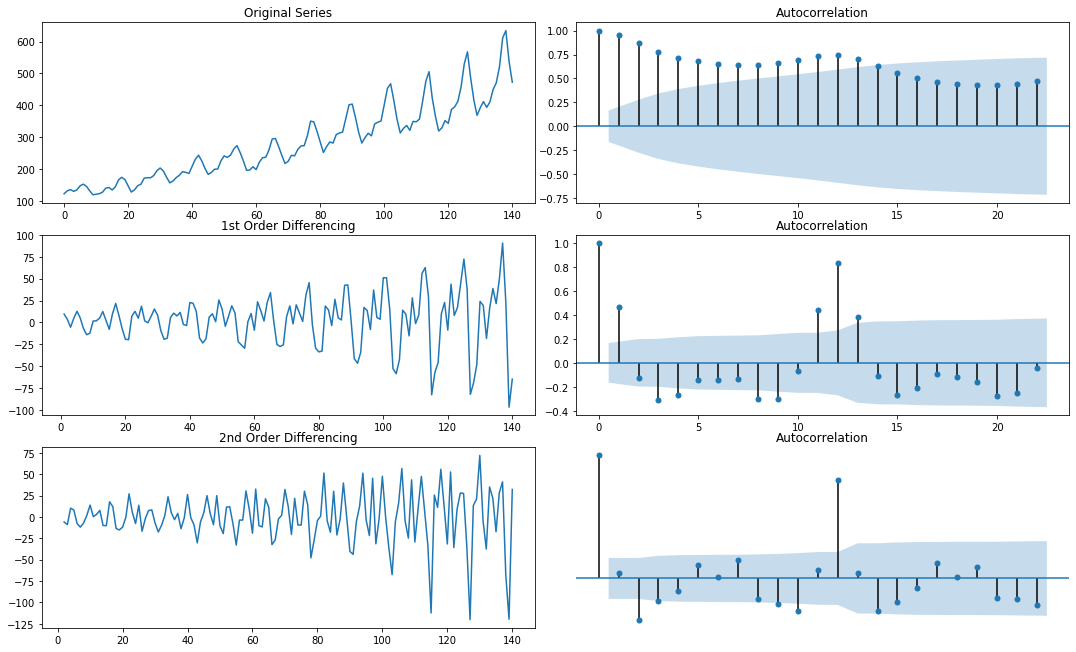

In [28]:
'parameter D : the order of differencing'

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Original Series
fig, axes = plt.subplots(3, 2)
fig.tight_layout()
axes[0, 0].plot(df.Passengers); axes[0, 0].set_title('Original Series')
plot_acf(df.Passengers, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(df.Passengers.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(df.Passengers.diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(df.Passengers.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(df.Passengers.diff().diff().dropna(), ax=axes[2, 1])

plt.axis('off')
plt.show()

## Plot model diagnostics

In [ ]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()

In [ ]:
'make predictions'
pred = results.get_prediction(start=pd.to_datetime('1949-03-01'), dynamic=False,full_results=True)
pred_ci = pred.conf_int()

In [ ]:
ax = predicted.plot(label='Observed', figsize=(15, 6))
pred.predicted_mean.plot(ax=ax, label='predicted', alpha=.7)

ax.set_xlabel('Date')
ax.set_ylabel('Airline Passengers')
plt.legend()

plt.show()

In [ ]:
trainScore = math.sqrt(mean_squared_error(predicted, pred.predicted_mean))
print('Train Score: %.2f RMSE' % (trainScore))